In [1]:
import os, csv, random, time

from __future__ import division
from matplotlib import  pyplot as plt
from scipy import stats, optimize
from collections import deque
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import bernoulli,poisson,norm,expon
from multiprocessing import Process, Lock
# from pathos.multiprocessing import ProcessingPool as Pool

import numpy as np
import scipy.io as sio
import seaborn as sns

%matplotlib inline

# Generate score for videos, and find all possible pairs

In [17]:
video_num = 30
global video_score
video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

print 'Total number of pairs for %d videos is: ' %video_num, total_pairs

Total number of pairs for 30 videos is:  435


# SGD
Assuming the pair $(w_i,w_j)$ means $w_i > w_j$, this function calculates $\frac{\partial L}{\partial w_i} = \frac{exp(w_j-w_i)}{1+exp(w_j-w_i)}$, where $w_i$ represent the weight to be taken derivative of. Return value is the gradient of the log likelihood function with respect to $w_i$

In [18]:
def calc_gradient(pairs, w, w_i):
    gradient = 0
    
    for pair in pairs:
        if w_i == pair[0]:
            out = -1
        elif w_i == pair[1]:
            out = 1  
        else:
            out = 0
            
        gradient -= out/(1/(np.exp(w[pair[1]]-w[pair[0]]))+1)
    
    return gradient

$w_{old}$ saves the original values of the gradient, so that later when updating the values, the values to be updated are still using the original value

In [19]:
def update_gradient(pairs, w, eta):
    w_old = w
    for i in range(len(w)):
        w[i] += eta*calc_gradient(pairs, w_old, i)
    return w

In [20]:
def likelihood(pairs, w):
    l = 1
    for pair in pairs:
        l += np.log(1+np.exp(w[pair[1]]-w[pair[0]]))
    return l

In [22]:
global w
w = np.zeros(video_num)
num_test_pairs = int(0.15* total_pairs)

pairs = [pairs_truth[i] for i in random.sample(range(total_pairs), num_test_pairs)]
results = []

like_prev = 100000
for i in range(15000):
    
    w = update_gradient(pairs, w, 0.001)
    if i % 1000 ==0:
        like =  likelihood(pairs_truth, w)
#         if like_prev < like:
#             break
        like_prev = like
        print i % 1000, like
    results.append(w[0])
    

302.22679781
193.313818028
169.544050022
159.103386913
153.246591798
149.502506454
146.903451507
144.996942306
143.545392233
142.412900334
141.516201151
140.801232371
140.231086987
139.77944479
139.426810849


Result Order 	 True Order 	 Result Score 	 Ture Score
19 		27 		1.35067309079 		3.8
29 		20 		4.71807017373 		2.2
6 		5 		-3.40127225504 		-3.8
18 		19 		1.16249588371 		1.8
14 		18 		-0.137879016376 		1.5
0 		0 		-5.95255514363 		-5.0
21 		16 		1.71590457969 		0.6
24 		29 		3.21391692981 		4.8
22 		13 		1.84519316602 		-0.0
1 		8 		-4.17663736582 		-2.3
23 		28 		1.91328550227 		4.0
12 		12 		-0.513834532617 		-0.4
4 		7 		-3.54222426963 		-3.3
20 		21 		1.46128798256 		2.6
13 		15 		-0.333986201563 		0.2
9 		10 		-1.77038475359 		-1.9
26 		25 		3.61214243855 		3.5
16 		17 		0.568386339357 		1.2
10 		6 		-1.50127099607 		-3.3
5 		3 		-3.41388023048 		-4.5
27 		26 		3.6456892746 		3.8
25 		22 		3.46305111663 		2.7
2 		4 		-3.73856682815 		-4.5
7 		2 		-1.95128543202 		-4.8
15 		14 		-0.0981777438419 		0.2
8 		11 		-1.94917421354 		-1.8
11 		9 		-1.09863526265 		-2.2
17 		23 		0.64973661096 		3.1
3 		1 		-3.56601514896 		-5.0
28 		24 		4.52594635783 		3.5


(array([ 2.,  8.,  5.,  3.,  3.,  4.,  1.,  1.,  1.,  2.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

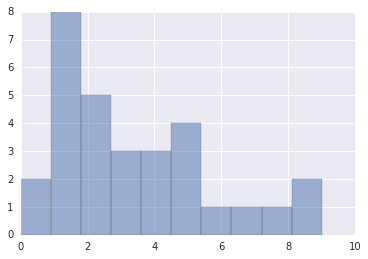

In [23]:
def matching_func(param):
    """
    Function used to calculate L2 norm of v and w_star. Used to find a and b.
    Here params is [a, b]
    """
    return np.linalg.norm(video_score - param[0]*np.array(w) - param[1])


def regularized_vector():
    
    coeff = optimize.minimize(matching_func, [0, 0])

    a = coeff['x'][0]
    b = coeff['x'][1]
    v = a*np.array(w)+b
    return v

v = regularized_vector()

true_order = np.array(video_score).argsort()
true_ranks = true_order.argsort()

temp_o = np.array(w).argsort()
temp_r = temp_o.argsort()

resolution = 0.1
video_score_results = np.round(np.array(results)/resolution)*resolution

print 'Result Order \t True Order \t Result Score \t Ture Score'
for i in range(len(temp_r)):
    print temp_r[i], '\t\t', true_ranks[i], '\t\t', v[i], '\t\t', video_score[i]
    
diff = np.abs(temp_r - true_ranks)
plt.hist(diff, alpha=0.5)

# Generate Data using Generative function 

In [ ]:
video_score

In [7]:
from multiprocessing import Pool


def f(i):
    print 'Evaluating trait %d', i+1
    model = Pairwise(pairs[i])
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=1000000, maxfun=1000000)
    estimated_for_each_trait[str(i)] = results.params
    return estimated_for_each_trait

def mp_handler():
    p = multiprocessing.Pool(2)
    p.map(f, [0,1,2,3,4])
    
mp_handler()

NameError: global name 'multiprocessing' is not defined

In [8]:
def update_gradient_concur(pairs, w):
    w_old = w
    eta = 0.01
    for i in range(len(w)):
        w[i] += eta*calc_gradient(pairs, w_old, i)
    return w

In [ ]:
import multiprocessing

w = np.zeros(30)
pairs = pairs_truth

p = multiprocessing.Pool(2)

for i in range(10000):
    w = p.map(update_gradient_concur, pairs, w)
    if i % 500 ==0:
        print likelihood(pairs_truth, w)
        
    


    p = multiprocessing.Process(target=update_gradient_concur, args=(pairs, w,))
    p.start()
    p.join()

In [41]:
def update_gradient_concur(pairs, w):
    import numpy as np
#     print pairs # result is a list of pairs
    w_old = w[0]
    w = w[0]
    eta = 0.01
    for i in range(len(w)):
        gradient = 0
    
        for pair in pairs:
            if i == pair[0]:
                out = -1
            elif i == pair[1]:
                out = 1  
            else:
                out = 0
            
        gradient -= out/(1/(np.exp(w_old[pair[1]]-w_old[pair[0]]))+1)
        
        w[i] += eta*gradient
    return w

def likelihood(pairs, w):
    l = 1
    w = w[0]
    for pair in pairs:        
        l += np.log(1+np.exp(w[pair[1]]-w[pair[0]]))
    return l

w = np.zeros(30)

for i in range(10000):
    w = Pool().map(update_gradient_concur, [pairs_truth], [w])
    if i % 500 ==0:
        print likelihood(pairs_truth, w)

print res

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
num_test_pairs = (0.2* self.total_pairs).astype(int)

test_pairs = [self.pairs_truth[i] for i in random.sample(range(self.total_pairs), num_test_pairs)]
self.endog = np.array(test_pairs)

w_init = np.random.uniform(-5,5,video_num)
self.fit(w_init)

if showResult:
    res = self.rank[0]
    compare_rank(self.w_star, res, False, True)
    plt.legend([str(i) for i in num_test_pairs])  
if Nihar:
    output_error_nihar.append(self.performance_nihar())
if Isabelle:
    output_error_isabelle.append(self.performance_isabelle())
